# Graph Theory and Catan: creating the most balanced board setup

<font size="4"> 

In the game of Catan, each game a new playing board is laid out by the players. First the tiles are laid out. Then each location is assigned a particular roll outcome from a two dice roll and yields a resource card if that number is rolled. Theoretically the board is randomized every time, but there is an order to the dice roll tiles to bring a little more balance to things. That said, you skip the desert (a non resource yielding tile) and where the desert is and how you skip is is critical to the balance of the game. 
    
<br/>


    
So how do you create the most balanced Catan layout? (We will look at only resource yields rather than what specific resource it is for now). Using the alphabetical order that go with the number tiles (5,2,6,3 etc) is a good starting point. It creates a pretty well balanced board in the ideal case of the desert ending up in the middle. But one of the great things about Catan is that the resource fields can be arranged randomly to give a fresh board and unique resource distribution each game. The ideal case of desert in the middle only occurs organically one in nineteen times. Usually the desert will be in the first or second ring or hexes. How do you optimally skip the desert? When you jump from one ring to the next should you rotate the second ring to make sure to avoid overpowered spots (think 6 or 8 next to another 6 or 8)? With the desert in the middle you should be fine, but once you skip over a desert in the first or second ring it gets tricky. What about when you encounter the desert in the second or first ring? Should you skip directly over it and proceed to next square or go around it to try and preserve the adjancecy of nodes. 
    
    
<br/>

As a fun project, I've created a simulated board using a graph where resource fields are the nodes, hexes that share a side (ie a road location in between them) are neighbors, and each 3 node face is a settlement location. From here I can simulate each number tile distribution order and evaluate relative numeric power of each settlement location. A nine or five is twice as likely to be rolled as say an eleven or three. Sixes and eights are the second most likely and sevens are the most likely, though sevens are not on the board as a seven triggers the robber. From there we can find some strategy to set up an optimally balanced board. 
      
</font>

In [1]:
# The catan board has 19 tiles, 18 letters and 1 desert. In the adjacency matrix the tiles will be aranged as follows
# from 0 to 18

#         0   1   2

#       3   4   5   6

#     7   8   9   10  11

#      12  13   14  15

#       16   17   18

### Creating a graph

In [2]:
import numpy as np
from IPython.display import SVG
from scipy import sparse
from scipy.sparse import csr_matrix

from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph

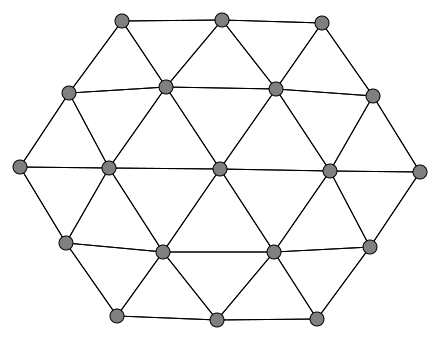

In [60]:
# First we create an undirected graph of all the edges in the board (ie neighboring tiles)

edgelist = [(0, 1),   (0, 11),   (0, 12),
            (1,2), (1,13), (1,12),
            (2, 3), (2, 13),
            (11, 12), (11, 17), (11,10),
            (12, 13), (12, 18), (12, 17),
            (13, 3), (13, 14), (13, 18),
            (3, 4), (3, 14),
            (4, 14), (4, 5),
            (5, 14), (5, 15), (5, 6),
            (14, 15), (14, 18),
            (18, 17), (18, 16), (18, 15),
            (10, 17), (10, 9),
            (17, 9), (17, 16),
            (6, 15), (6, 7),
            (15, 16), (15, 7),
            (16, 7), (16, 8), (16,9),
            (8,7),(8,9)
           ]

adjacency = edgelist2adjacency(edgelist, undirected=True)

image = svg_graph(adjacency)
SVG(image)  

<font size="4"> 


Constructing this graph with scipi matrix tools gives a lovely graph illustration that actually looks like a catan board! I think were on the right track. You can consider each vertex (gray dot) a resource field and every edge a road location and every triangular face a possible settlement location.
    
<br/>
    
Now we create a quick adjacency matrix and find all the triplets in the graph
</font>

In [4]:
adj_list = {}

matrix = adjacency.toarray().astype(int)

for i in range(0,19):
    adj_list[i] = []

for i in range(0,19):
    for j in range(0,19):
        if matrix[i][j]==1:
            adj_list[i].append(j)

#adj_list

In [5]:
def triplets(node, graph):
    triplets = []
    node_neighbors = graph[node]
    #print('*** neighbors of ', node,' are ',node_neighbors,'***')
    #iterate though neighbors of the node youre doing
    for i in node_neighbors:
        #print('\ncurrent neighbor of node',node,'is',i)
        neighbor_neighbors = graph[i]
        #print('neighbors of neighbor',i, 'is', neighbor_neighbors)
        for j in neighbor_neighbors:
            if j in node_neighbors:
                if {node,i,j} not in triplets:
                    triplets.append({node,i,j})

    return(triplets)
#triplets(0, adj_list)

all_faces = []

for i in range(0,19):
    node_triplets = triplets(i, adj_list)
    for i in node_triplets:
        if i not in all_faces:
            all_faces.append(i)
#all_faces

<font size="4"> 

Now we have all the faces of the graph i.e. all the possible settlement locations, we can assign them their number tile (a tuple of (label, dice roll, power))
    
<br/>

'Power' is the likelihood of getting hit in quantities of 1/36ths (2.78%), i.e. a 6 or 8 has a 5/36th (~14%) chance of getting rolled each turn. A powerful 8-5-9 intersection has a 13/36th or 36.1% chance of yielding a resource to a settlement each time the dice are rolled.  
    
    
Here is a quick little chart showing the probabilities of dice rolls.
    

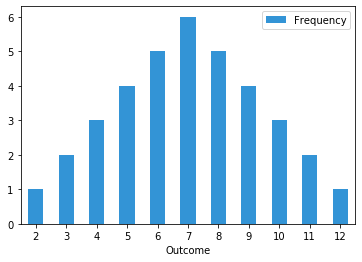

In [6]:
import pandas as pd

roll_outcomes = np.zeros((6,6), dtype=int)

for i in range(1,7):
    for j in range(1,7):
        roll_outcomes[i-1,j-1] = j+i

roll_freq = pd.DataFrame(data={"Outcome":np.unique(roll_outcomes, return_counts=True)[0], 
                               "Frequency":np.unique(roll_outcomes, return_counts=True)[1]})

roll_freq.plot.bar(x='Outcome', y='Frequency', rot=0, color='#007acc', alpha=0.8)

In [7]:
# Letter encodings are as follow: 
# A:5, B:2, C:6, D:3, E:8, F:10, G:9, H:12, I:11,
# J:4, K:8, L:10, M:9, N:4, O:5, P:6, Q:3, R:11

# the '#' sign denotes desert

letters = [("A","5",4),  # 0
           ("B","2",1),  # 1
           ("C","6",5),  # 2
           ("D","3",2),  # 3
           ("E","8",5),  # 4
           ("F","10",3), # 5
           ("G","9",4),  # 6
           ("H","12",1), # 7
           ("I","11",2), # 8
           ("J","4",3),  # 9
           ("K","8",5),  # 10
           ("L","10",3), # 11
           ("M","9",4),  # 12
           ("N","4",3),  # 13
           ("O","5",4),  # 14
           ("P","6",5),  # 15
           ("Q","3",2),  # 16
           ("R","11",2), # 17
           ("#","#",0)   # 18
          ]

In [8]:
# quick board display function
def printboard(order,type):
    # type == 0 for letter, 1 for number, 2 for power
    # numbers seem jumbled up but thats becuase it snakes around the board, more on this later
    print("     ",order[0][type],"   ", order[1][type],"   ", order[2][type],'\n')
    print("  ",order[11][type],"   ", order[12][type],"   ", order[13][type],"   ", order[3][type],'\n')
    print(order[10][type],"   ", order[17][type],"   ", order[18][type],"   ", order[14][type],"   ", order[4][type],'\n')
    print("  ",order[9][type],"   ", order[16][type],"   ", order[15][type],"   ", order[5][type],'\n')
    print("     ",order[8][type],"   ", order[7][type],"   ", order[6][type],'\n') 

<font size="4">    
Here is an ideal board with letters in order snaking around board and the desert in the middle
</font>

In [9]:
printboard(letters,0)

      A     B     C 

   L     M     N     D 

K     R     #     O     E 

   J     Q     P     F 

      I     H     G 



<font size="4">    
Now that we 'flip the tiles' these are the dice numbers
</font>

In [10]:
printboard(letters,1)

      5     2     6 

   10     9     4     3 

8     11     #     5     8 

   4     3     6     10 

      11     12     9 



<font size="4">    
And here as dice numbers converted into their power weights. Notice none of the five power numbers (6 or 8) are next to each other (which would be massively overpowered, but also no (5, 4, 4) power settlement location e.g. (6, 5, 9) or (8, 5, 9). These can be avoided with perfect theoretical board of a middle desert. Currenly there is no point with more than 12 points of production.
</font>

In [11]:
printboard(letters,2) # i.e. productive likelihood

      4     1     5 

   3     4     3     2 

5     2     0     4     5 

   3     2     5     3 

      2     1     4 



<font size="4">    
Lets look at every intersection:
</font>

In [12]:
def intersections(all_faces, order):
    all_intersections = []
    for i in all_faces:
        l = ["","",0]
        for j in i:
            l[0] += order[j][0]
            if l[1] != "":
                l[1] += ", "+order[j][1]
            else:
                l[1] += order[j][1]
            l[2] += order[j][2]
        all_intersections.append(l)
    return(sorted(all_intersections, key=lambda x: x[2], reverse=True))

print("[ NAME    NUMBERS   POWER]")
intersections(all_faces, letters)

[ NAME    NUMBERS   POWER]


[['EFO', '8, 10, 5', 12],
 ['FGP', '10, 9, 6', 12],
 ['FOP', '10, 5, 6', 12],
 ['ALM', '5, 10, 9', 11],
 ['DEO', '3, 8, 5', 11],
 ['CDN', '6, 3, 4', 10],
 ['PGH', '6, 9, 12', 10],
 ['JKR', '4, 8, 11', 10],
 ['RKL', '11, 8, 10', 10],
 ['ABM', '5, 2, 9', 9],
 ['BCN', '2, 6, 4', 9],
 ['DNO', '3, 4, 5', 9],
 ['RLM', '11, 10, 9', 9],
 ['#OP', '#, 5, 6', 9],
 ['BMN', '2, 9, 4', 8],
 ['QPH', '3, 6, 12', 8],
 ['IJQ', '11, 4, 3', 7],
 ['QJR', '3, 4, 11', 7],
 ['#MN', '#, 9, 4', 7],
 ['#NO', '#, 4, 5', 7],
 ['Q#P', '3, #, 6', 7],
 ['R#M', '11, #, 9', 6],
 ['IQH', '11, 3, 12', 5],
 ['QR#', '3, 11, #', 4]]

<font size="4">    
As you can see this board is *very* balanced. Incredibly so, not even a (6, 5, 9) or (8, 5, 9) which has a dice weight of 13 and is usually present in boards where the desert is not in the middle. 
    
<br />
    
It's a bit of an oversimplificaiton and in later in another post I'll look at other aspects of the game (optimal two settlement setups, blocking players off of adjacent settlement locations and some stats on balancing raw resouce production versus a diversity of resources) but for now lets just see if we can create equally good boards with the desert not in the middle. I occasionlly raise the issue of putting the desert in the middle for optimal balance and people usually insist on keeping it on the outer ring, claiming to enjoy the mildly overpowered points. A couple strong points for the first and second player to scoop up helps balance out the critial ability to plan out both settlements more that the third and especially fourth player to place have. 

  
    
<br />
    
Lets do this again and stick the desert somewhere in the first ring (first 12). Putting it in the first 12, and then we'll skip directly 'over' it rather than around, ie continue in the original pattern simply skipping the desert rather than placing around it.
</font>

In [13]:
des_1st_ring_skip = letters.copy()
des_1st_ring_skip.insert(4, des_1st_ring_skip.pop()) #stick the desert into the fifth spot

printboard(des_1st_ring_skip, 0)
intersections(all_faces, des_1st_ring_skip)

      A     B     C 

   K     L     M     D 

J     Q     R     N     # 

   I     P     O     E 

      H     G     F 



[['POG', '6, 5, 9', 13],
 ['AKL', '5, 8, 10', 12],
 ['EFO', '8, 10, 5', 12],
 ['ENO', '8, 4, 5', 12],
 ['CDM', '6, 3, 9', 11],
 ['OFG', '5, 10, 9', 11],
 ['PRO', '6, 11, 5', 11],
 ['BCM', '2, 6, 9', 10],
 ['HPG', '12, 6, 9', 10],
 ['QJK', '3, 4, 8', 10],
 ['QKL', '3, 8, 10', 10],
 ['DMN', '3, 9, 4', 9],
 ['PIQ', '6, 11, 3', 9],
 ['RLM', '11, 10, 9', 9],
 ['RMN', '11, 9, 4', 9],
 ['RNO', '11, 4, 5', 9],
 ['PQR', '6, 3, 11', 9],
 ['ABL', '5, 2, 10', 8],
 ['BLM', '2, 10, 9', 8],
 ['#EN', '#, 8, 4', 8],
 ['HIP', '12, 11, 6', 8],
 ['IJQ', '11, 4, 3', 7],
 ['QRL', '3, 11, 10', 7],
 ['D#N', '3, #, 4', 5]]

<font size="4">    
 *** insert figure 1 of direct skip over above *** 
    
<br />

    
So desert is on the outside, and we just skipped right over it. Lets contrast that with going around it (ie placing where the N tile is now). Interestingly in this special case of desert on edge very very few of the numbers have changed positions when you go around the edge desert rather than skip. You can see it programatically too as you only swap three elements of the list.
<br />
    

 *** insert figure 2 of skip around below *** 


</font>

In [14]:
des_1st_ring_around = letters.copy()
des_1st_ring_around.insert(13, des_1st_ring_around.pop(4)) # put E where the O goes
des_1st_ring_around.insert(17, des_1st_ring_around.pop(14)) # put the O almost at the end
des_1st_ring_around.insert(4, des_1st_ring_around.pop(-1)) # put the desert in between the D & F

printboard(des_1st_ring_around,0)
intersections(all_faces, des_1st_ring_around)

      A     B     C 

   L     M     N     D 

K     R     O     E     # 

   J     Q     P     F 

      I     H     G 



[['OEP', '5, 8, 6', 14],
 ['FEP', '10, 8, 6', 13],
 ['FGP', '10, 9, 6', 12],
 ['ONE', '5, 4, 8', 12],
 ['ALM', '5, 10, 9', 11],
 ['OMN', '5, 9, 4', 11],
 ['QOP', '3, 5, 6', 11],
 ['CDN', '6, 3, 4', 10],
 ['DNE', '3, 4, 8', 10],
 ['PGH', '6, 9, 12', 10],
 ['JKR', '4, 8, 11', 10],
 ['RKL', '11, 8, 10', 10],
 ['ROM', '11, 5, 9', 10],
 ['ABM', '5, 2, 9', 9],
 ['BCN', '2, 6, 4', 9],
 ['RLM', '11, 10, 9', 9],
 ['BMN', '2, 9, 4', 8],
 ['#FE', '#, 10, 8', 8],
 ['QPH', '3, 6, 12', 8],
 ['QRO', '3, 11, 5', 8],
 ['D#E', '3, #, 8', 7],
 ['IJQ', '11, 4, 3', 7],
 ['QJR', '3, 4, 11', 7],
 ['IQH', '11, 3, 12', 5]]

<font size="4">    

Yikes okay going over rather than around is much better for when the desert in in one of the six corners, but lets just check the case where the tile is in the center edge. (You could say.. the edge case lol)
    
<br/>
There are six corner spots and 6 outer ring spots not in the corner. These are the center edge spots.  

<img src="corner.jpeg">

<font size="4">    


This above is a corner, while this below is an edge. Pretty straight forward.

<img src="edge.jpeg">

In [17]:
des_1st_ring_edge_skip = letters.copy()
des_1st_ring_edge_skip.insert(5, des_1st_ring_edge_skip.pop()) #stick the desert into the fifth spot

printboard(des_1st_ring_edge_skip, 0)
intersections(all_faces, des_1st_ring_edge_skip)

      A     B     C 

   K     L     M     D 

J     Q     R     N     E 

   I     P     O     # 

      H     G     F 



[['POG', '6, 5, 9', 13],
 ['AKL', '5, 8, 10', 12],
 ['CDM', '6, 3, 9', 11],
 ['OFG', '5, 10, 9', 11],
 ['PRO', '6, 11, 5', 11],
 ['BCM', '2, 6, 9', 10],
 ['DEN', '3, 8, 4', 10],
 ['HPG', '12, 6, 9', 10],
 ['QJK', '3, 4, 8', 10],
 ['QKL', '3, 8, 10', 10],
 ['DMN', '3, 9, 4', 9],
 ['PIQ', '6, 11, 3', 9],
 ['RLM', '11, 10, 9', 9],
 ['RMN', '11, 9, 4', 9],
 ['RNO', '11, 4, 5', 9],
 ['PQR', '6, 3, 11', 9],
 ['ABL', '5, 2, 10', 8],
 ['BLM', '2, 10, 9', 8],
 ['E#N', '8, #, 4', 8],
 ['HIP', '12, 11, 6', 8],
 ['#FO', '#, 10, 5', 7],
 ['#NO', '#, 4, 5', 7],
 ['IJQ', '11, 4, 3', 7],
 ['QRL', '3, 11, 10', 7]]

<font size="4">    



Not super balanced, but not overly unbalanced. For now it may seem that going over rather than around is superior but lets do the around case for a middle edge spot. (And actually we're starting on a specific spot, more on that later)

In [34]:
des_1st_ring_edge_around = letters.copy()
des_1st_ring_edge_around.insert(5, des_1st_ring_edge_around.pop())
des_1st_ring_edge_around.insert(15, des_1st_ring_edge_around.pop(6))
des_1st_ring_edge_around.insert(15, des_1st_ring_edge_around.pop(6))
des_1st_ring_edge_around.insert(18, des_1st_ring_edge_around.pop(16))

#des_1st_ring_edge_around
printboard(des_1st_ring_edge_around, 0)
intersections(all_faces, des_1st_ring_edge_around)

      A     B     C 

   M     N     O     D 

L     R     P     F     E 

   K     Q     G     # 

      J     I     H 



[['PNO', '6, 4, 5', 12],
 ['POF', '6, 5, 10', 12],
 ['PFG', '6, 10, 9', 12],
 ['AMN', '5, 9, 4', 11],
 ['CDO', '6, 3, 5', 11],
 ['QPG', '3, 6, 9', 11],
 ['BCO', '2, 6, 5', 10],
 ['DEF', '3, 8, 10', 10],
 ['JKQ', '4, 8, 3', 10],
 ['KLR', '8, 10, 11', 10],
 ['RPN', '11, 6, 4', 10],
 ['DOF', '3, 5, 10', 9],
 ['QKR', '3, 8, 11', 9],
 ['RLM', '11, 10, 9', 9],
 ['RMN', '11, 9, 4', 9],
 ['QRP', '3, 11, 6', 9],
 ['ABN', '5, 2, 4', 8],
 ['BNO', '2, 4, 5', 8],
 ['E#F', '8, #, 10', 8],
 ['QGI', '3, 9, 11', 8],
 ['#FG', '#, 10, 9', 7],
 ['GHI', '9, 12, 11', 7],
 ['JQI', '4, 3, 11', 7],
 ['#HG', '#, 12, 9', 5]]

<font size="4">    

Interestingly (and to my sincere surprise) we now get a *very* balanced board. Three 12 point spots, then three 11 point spots and then a bunch of 10 point spots is incredible. It has the same relative balance as the theoretically optimal setup with the desert in the middle (theoretically ideal, through people seem to hate playing on a center desert map). The board also isn't 'too balanced', giving the first player to place (who is also the last player to place) a pick of the highest producing spots. Generalizing the actual resources and their relative scarcities (in a later post I might add this to the model), the first three players can choose to grab the highest producing spots and then the last player to place (traditionally the most desired placement order as they can place both settlements at once) will be left with the 11 point spots or an resource undesirable 12 point spot.  
    
<br/>

    
    
The final two points, R & Q are can theoretically be switched as they have the same power value, though putting the Q at the bottom and the R at the left (from the bottom orientation) may be best as to keep the 11's non-adjacent which would make a highly variable (feast or famine) placement. It is critical that the P remains in the middle as it is a 6 (with a power score of 5, so relatively high producing field). 

<br/>


I'm not kidding, this is literally the most balanced setup and it still keeps the desert on the outside ring. To get it to work you have to start with the A tile (the first number tile) on the corner opposite the desert, the 'top right' tile if you're looking down at the board and go clockwise. 

<img src="edge_annotated.jpeg">

<font size="4">    

Maybe its too much work, or maybe you prefer a slighly unbalanced board to help the first players compete with the double placement of the fourth player, but its a fun setup and one worth trying.